In [2]:
# Numerical Libraries
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.tools.measurements import obs_vs_time, ED_state_vs_time
from quspin.tools.block_tools import block_diag_hamiltonian,block_ops #for block diagonalization
from quspin.tools.evolution import expm_multiply_parallel # expm_multiply_parallel
import numpy as np # generic math functions
from numpy import linalg as LA
import scipy as sp
from scipy import integrate

In [3]:
#Plotting Libraries
import matplotlib.pyplot as plt  
from cycler import cycler
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])

plt.rc("axes", prop_cycle=standard_cycler)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{newpxtext}\usepackage{newpxmath}\usepackage{commath}\usepackage{mathtools}")
plt.rc("font", family="serif", size=18.)
plt.rc("savefig", dpi=200)

plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)

# Bose hubbard with complex hopping

## Hamiltonian

The hamiltonian describing the dynamics of $N$ spinless bosons with on-site interaction over a lattice of size $L$ is given by the Bose-Hubbard model,

 $$ H=-J\sum_{l=0}^{L-1}(e^{i\theta}b^{\dagger}_{l+1}b_{l}+h.c)+\frac{U}{2}\sum_{l=0}^{L}n_{l}(n_{1}-1) $$

Here we add an complex amplitude phase to break the usual Time reversal and have a more simple hamiltonian form the unitary symmetry class. This was presented by (Kolovsky 2015, Bose-hubbard a quantum chaos approach). As we are considering a closed chain the global symmetry is parity, and at the moment to 

## Hilbert space basis

In [4]:
L=7 # lattice sites
N=8 # number of bosons

In [5]:
# Coupling constants
# for L=9,N=8 and j=1, U=0.002 beautifully plot
J=1.0 # hopping
U=0.002 # interaction
theta=np.pi/6

hopping1=[[-J*np.exp(complex(0,theta)),i,i+1] for i in range(L-1)]
hopping2=[[-J*np.exp(complex(0,-theta)),i,i+1] for i in range(L-1)]

interaction=[[U/2.0,i,i] for i in range(L)]
potential=[[-U/2.0,i] for i in range(L)]

static=[["+-",hopping1],["-+",hopping2],["n",potential],["nn",interaction]]
dynamic=[]

#contruction of the parity block Hamiltonian

blocks=[dict(pblock=pblock) for pblock in [-1,1]] # blocks to project on to
basis_args = (L,N) # boson_basis_1d manditory arguments
#basis_kwargs = dict(Nb=N) # boson_basis_1d optional args
get_proj_kwargs = dict(pcon=True) # set projection to full particle basis

Hamiltonian = block_ops(blocks,static,dynamic,boson_basis_1d,basis_args,np.complex128,
				    get_proj_kwargs=get_proj_kwargs)


Hamiltonian.compute_all_blocks() #computes all the blocks

H_block=[]
for i in Hamiltonian.H_dict:
    H_block.append(Hamiltonian.H_dict[i])


P_block=[] #proyectors
for i in Hamiltonian.P_dict:
    P_block.append(Hamiltonian.P_dict[i])


Hermiticity check passed!
Particle conservation check passed!


/home/quantic/miniconda3/lib/python3.7/site-packages/quspin/tools/block_tools.py:469: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.boson.boson_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H = hamiltonian(self._static,self._dynamic,basis=b,dtype=self.dtype,**self._checks)


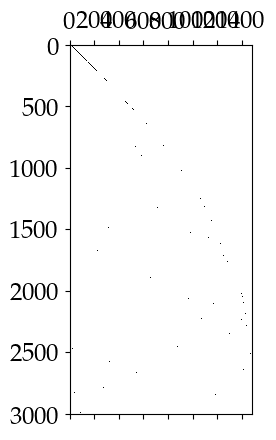

In [6]:
P_block[1].todense()

plt.spy(P_block[0].todense())
plt.show()

### *first we will full-diagonalize

In [7]:
H_energy,H_states=H_block[0].eigh() #diagonalizaition


Due the two-body interaction in the Hamiltonian the Matrix has an sparse structure, even in the fock space ocupation basis, however in the restircted parity subspace the Hamiltonian could look more random

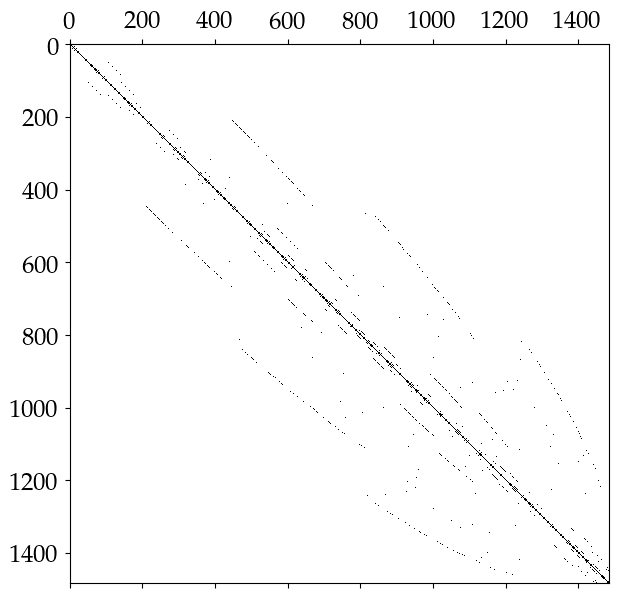

In [8]:
plt.figure(figsize=(10,7))

plt.spy(H_block[0].toarray())
#plt.spy(H_block[0].toarray())

plt.show()


## Espectral observables ##

### Density of states

The unormalized density of states $\rho(E)=\sum_{l}\delta(E-E_{l})$ allows us to gain intuition about the time scales. In particular for the Heisenberg time $t_{H}\sim \rho_{max}$, with $\rho_{max}$ the maximum value of the density of states (proportional to the minimum level spacing). 

11 22 38


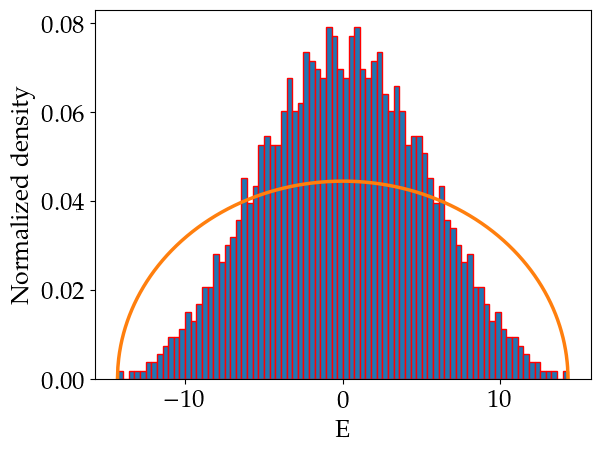

In [9]:
#bins options:
dim=H_block[0].Ns
bin_square=int(np.sqrt(dim)) # uses the bin=\sqrt(data)
bin_sturges=int(np.log2(dim)+1.0) # uses the sturges rule
bin_rice=int(2*(dim**(1.0/3))) # uses the sturges rule

print(bin_sturges,bin_rice,bin_square)

#An empirical test for the appropriate bin size is by require that the chosen bin size, 
# matches he height of the semi-circle distribution!

Ener=np.linspace(-abs(H_energy[0]),abs(H_energy[0]),1090)
GUE_semicricle=(2/(np.pi*abs(H_energy[0]**2)))*np.sqrt((H_energy[0]**2)-Ener**2)

rho_E, _,_=plt.hist(H_energy,edgecolor="red",bins=80,density=True)
plt.xlabel("E")
plt.ylabel("Normalized density")
plt.plot(Ener,GUE_semicricle,label = r"$P_{GUE}(r)$" )
plt.show()

### Comulative density function

The spectral density has the problem that, numerically, it needs the specification of tha bin size and therefore if one don't choses this bin size properly one may get into troubles. A better suited numerical quantity is the cumulative function,

$$ C(E)=\frac{1}{d}\int_{E_{min}}^{E}\rho(x) dx $$

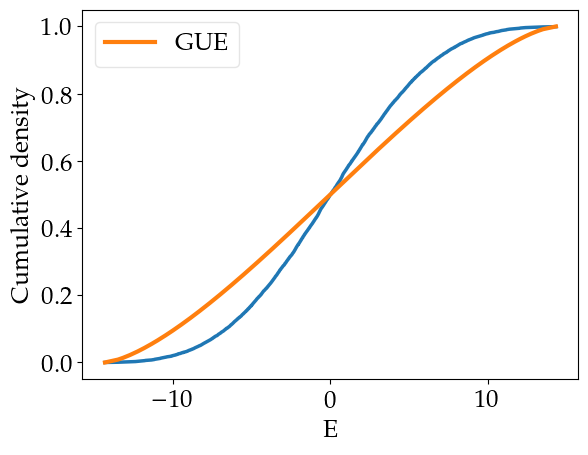

In [10]:
#Real comulative
CDF = np.arange(dim)/(dim) #Comulative density 

#GUE comulative
R=max(np.abs(H_energy[0]),np.abs(H_energy[-1])) #radius of the distribution
CDF_GUE=(1.0/2)+((H_energy/(np.pi*(R**2)))*np.sqrt((R**2)-(H_energy**2))) \
        +((1.0/np.pi)*np.arcsin(H_energy/R))

plt.plot(H_energy,CDF)
plt.plot(H_energy,CDF_GUE,label = r"GUE", linewidth = 3)
plt.xlabel("E")
plt.ylabel("Cumulative density")
plt.legend()
plt.show()

### Ratio of consecutive level spacings
 
A quantity that doesn't need an unfolding procedure is given by the distribution ratio of consecutive leves,

$$r_{l}=s_{l}/s_{l-1}$$

with $s_{l}=E_{l+1}-E_{l}$ the energy difference between a sorted spectrum $\{E_{l}\}$. This was introduced as an alternative to the common level spacing distributions for many-body systems where the unfolding procedure is rather cumbersome (see Y.Y Atas et all, 2013). For the three standard symmetry classes this distribution is given by the following surmise,

$$P(r) \propto \frac{(r+r^{2})^{\beta}}{(1+r+r^{2})^{1+(3/2)\beta}}$$

with $\beta$ the Dyson index and the normalization factor fixed by normalization.


In [11]:
spacings=[H_energy[i+1]-H_energy[i] for i in range(np.size(H_energy)-1)]
ratios=[]
for i in range(np.size(H_energy)-2):
         ratios.append( min(spacings[i+1]/spacings[i],spacings[i]/spacings[i+1]))



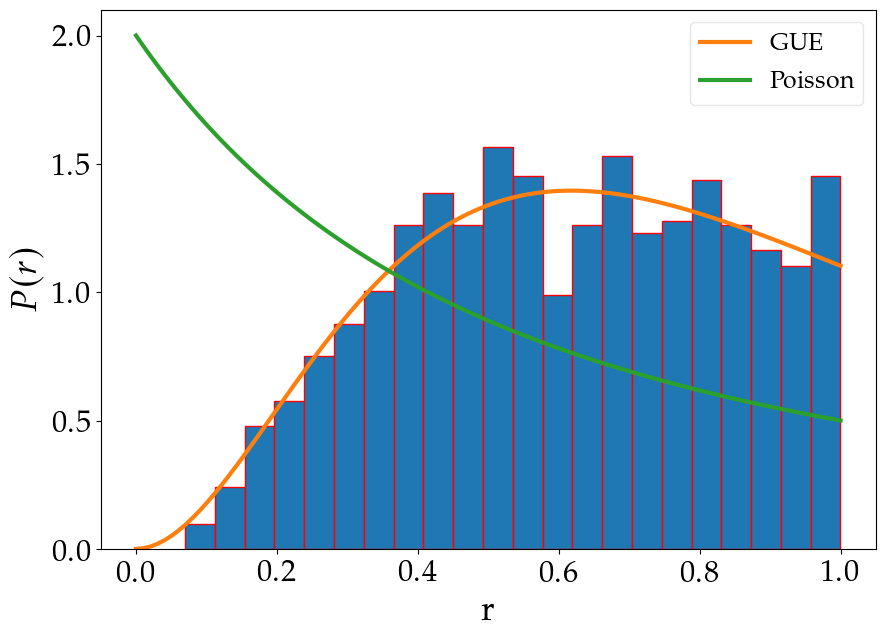

In [12]:
r=np.linspace(0,1,100)
pGUEr=2*(np.sqrt(3)*81/(4*np.pi))*((r+(r**2))**2)/((1.0+r+(r**2))**4)
poisson=2/(1+r)**2

plt.figure(figsize=(10,7))

plt.hist(ratios,density=True,edgecolor="red",bins=bin_rice)
plt.plot(r,pGUEr,label = r"GUE", linewidth = 3)
plt.plot(r,poisson,label = r"Poisson", linewidth= 3)

plt.ylabel(r"$ P(r)$", fontsize = 26)
plt.xlabel("r", fontsize = 25)
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.legend()

plt.show()

### Spectral form factor

The spectral form factor defined as $|Z(-\beta+it)|^{2}=\sum_{l,m}e^{-\beta(E_{l}+E_{m})+it(E_{l}-E_{m})}$, with $Z(-\beta+it)$ the analytic continued partition function is a natural quantity that captures the time dependence in spectral decoupled theories (e.g Haar and C-ensemble) and additionally captures relevant properties on the spectrum.

In [13]:
## Analytic continue partition function: 
#  input= a complex list of the form \beta+it

def Z(w):  
   z=[]
   for i in w:
       z.append(np.sum(np.exp(i*H_energy)))

   return np.array(z)

### Infinite temperature Form-factor

In [14]:
time=np.linspace(0.0,10000.0,500000) #time interval
R=Z((1j*time))
R=R*np.conjugate(R)/(dim**2) #normalized form factor
tmean_R=np.convolve(R.real, np.ones(5)/5, mode="same")

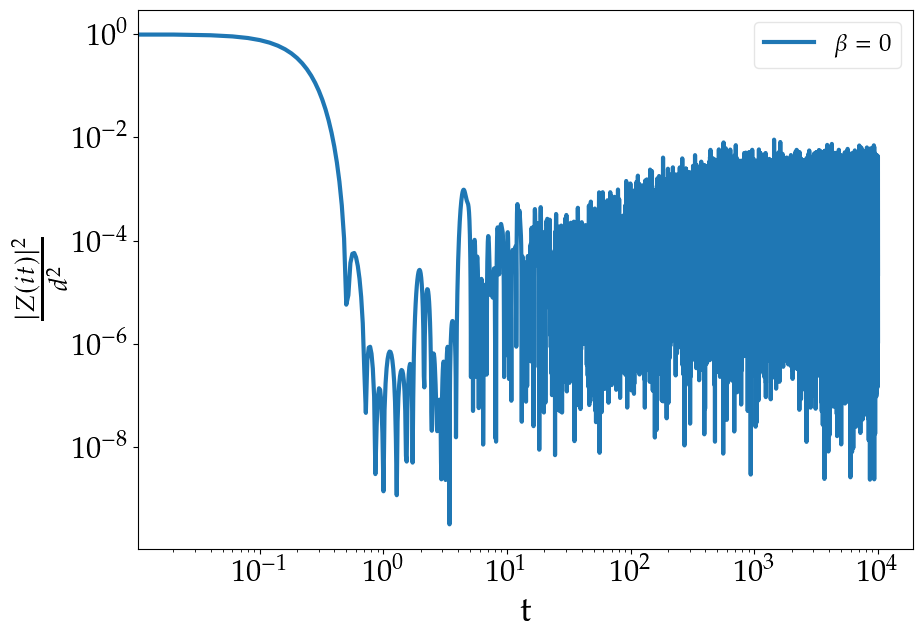

In [15]:
#plt.plot(time,tmean_R,color="blue",label="Time moving averaged form factor")

plt.figure(figsize=(10,7))
#plt.plot(time,tmean_R,color="red",label="Time moving averaged form factor")
plt.plot(time,R.real, label = r"$\beta=0$", linewidth = 3)

plt.yscale("log")
plt.xscale("log")

plt.ylabel(r"$ \frac{|Z(it)|^{2}}{d^{2}}$", fontsize = 26)
plt.xlabel("t", fontsize = 25)
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.legend()
plt.show()
#plt.savefig("<v^2>_vs_q_varios_E.jpg", dpi=300)

### Finite Temperature form factor

In [16]:
time=np.linspace(0.0,10000.0,500000) #time interval

R1=Z(-(1.0/2.0)+(1j*time)) # Z(-\beta\2 +it), \beta=1
partition1=np.sum(np.exp(-1.0*H_energy))
R1=R1*np.conjugate(R1)/(dim*partition1)

R3=Z(-(3.0/2.0)+(1j*time)) # Z(-\beta\2 +it)
partition3=np.sum(np.exp(-3.0*H_energy))
R3=R3*np.conjugate(R3)/(dim*partition3)

R5=Z(-(5.0/2.0)+(1j*time)) # Z(-\beta\2 +it)
partition5=np.sum(np.exp(-5.0*H_energy))
R5=R5*np.conjugate(R5)/(dim*partition5)


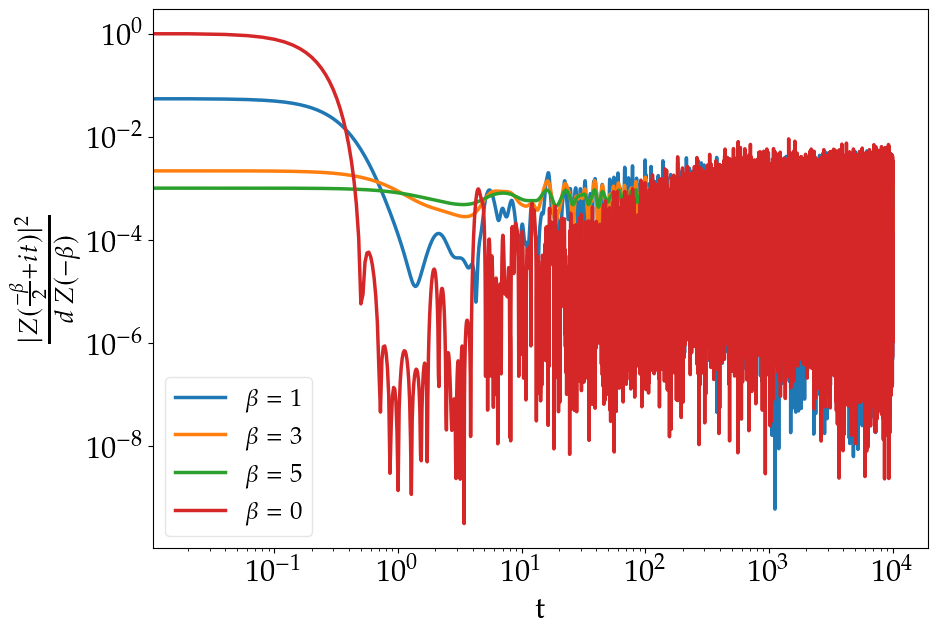

In [17]:
#plt.plot(time,tmean_R,color="blue",label="Time moving averaged form factor")

plt.figure(figsize=(10,7))

plt.plot(time,R1.real, label = r"$\beta=1$")
plt.plot(time,R3.real, label = r"$\beta=3$")
plt.plot(time,R5.real, label = r"$\beta=5$")
plt.plot(time,R.real, label = r"$\beta=0$")


plt.yscale("log")
plt.xscale("log")

plt.ylabel(r"$ \frac{|Z(\frac{-\beta}{2}+it)|^{2}}{d \,Z(-\beta)}$", fontsize = 26)
plt.xlabel("t",fontsize=22)
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.legend()
plt.show()
#plt.savefig("<v^2>_vs_q_varios_E.jpg", dpi=300)